In [ ]:
import sys, os
sys.path.append(os.path.abspath('../..'))

In [2]:
from tqdm.notebook import tqdm
import math
import gym
import torch
import torch.optim as optim 
from torch.utils.tensorboard import SummaryWriter
from collections import deque

from environments.simplified_KGW import KGW
from networks.dqn_KGW import DQN, MC_DQN
from utils.KGW_memory import RankedReplayMemory
from utils.optimization import AMN_perc_optimization
from utils.KGW_utils import fp, ActionSelector, evaluate
from utils.acquisition_functions import mc_random

import imageio
from utils.visualization import visualize_AMN

In [3]:
env = KGW()
c,h,w = c,h,w = fp(env.reset()).shape
n_actions = env.n_actions

In [4]:
BATCH_SIZE = 32
LR = 0.0000625
GAMMA = 0.99
EPS_START = 1.
EPS_END = 0.1
EPS_DECAY = 500000
TARGET_UPDATE = 10000
NUM_STEPS = 10000000
M_SIZE = 100000
POLICY_UPDATE = 10000
EVALUATE_FREQ = 50000
SAVE_FREQ = 100000

NAME = 'train_AMN_random_perc_5'
FEATURE_REGRESSION = False
PERCENTAGE = 0.05
REPLACEMENT=False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # if gpu is to be used
AMN_net = MC_DQN(n_actions).to(device)
# AMN_net = ENS_DQN(n_actions).to(device)
expert_net = torch.load("models/dqn_expert_KGW_model").to(device)
AMN_net.apply(AMN_net.init_weights)
expert_net.eval()
optimizer = optim.Adam(AMN_net.parameters(), lr=LR, eps=1.5e-4)
# optimizer = optim.Adam(AMN_net.parameters(), lr=LR, eps=1.5e-4)

/home/tony/anaconda3/envs/ml/lib/python3.7/site-packages/torch/serialization.py:593: SourceChangeWarning: source code of class 'networks.dqn_KGW.DQN' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [6]:
memory = RankedReplayMemory(M_SIZE, [5 * c,h,w], n_actions, mc_random, AMN_net, replacement=False, device=device)
# memory = LabeledReplayMemory(M_SIZE, [5,h,w], n_actions, mc_BALD, AMN_net, replacement=REPLACEMENT, device=device)
action_selector = ActionSelector(EPS_START, EPS_END, AMN_net, EPS_DECAY, n_actions, device)

In [7]:
steps_done = 0
writer = SummaryWriter(f'runs/{NAME}')

In [8]:
q = deque(maxlen=5)
done=True
eps = 0
episode_len = 0

In [9]:
progressive = tqdm(range(NUM_STEPS), total=NUM_STEPS, ncols=400, leave=False, unit='b')
for step in progressive:
  if done:
    env.reset()
    sum_reward = 0
    episode_len = 0
    img, _, _, _ = env.step(1) # BREAKOUT specific !!!
    for i in range(10): # no-op
      n_frame, _, _, _ = env.step(0)
      n_frame = fp(n_frame)
      q.append(n_frame)
        
  train = len(memory) > 50000
  # Select and perform an action
  state = torch.cat(list(q))[8:].unsqueeze(0)
  action, eps = action_selector.select_action(state, training=train)
  n_frame, reward, done, info = env.step(action)
  n_frame = fp(n_frame)

  # 5 frame as memory
  q.append(n_frame)
  memory.push(torch.cat(list(q)).unsqueeze(0), action, reward, done) # here the n_frame means next frame from the previous time step
  episode_len += 1

  # Perform one step of the optimization (on the target network)
  if step % POLICY_UPDATE == 0:
    loss = AMN_perc_optimization(AMN_net, expert_net, optimizer, memory, feature_regression=FEATURE_REGRESSION,
                                 training=train, batch_size=BATCH_SIZE, percentage=PERCENTAGE, device=device)
    if loss is not None:
      writer.add_scalar('Performance/loss', loss, step)
    
    
  if step % EVALUATE_FREQ == 0:
    evaluated_reward = evaluate(step, AMN_net, device, env, n_actions, eps=0.05, num_episode=15)
    writer.add_scalar('Performance/reward', evaluated_reward, step)
    
  if step % SAVE_FREQ == 0:
    torch.save(AMN_net, "models/dqn_AMN_KGW_random_model")

In [10]:
torch.save(AMN_net, "models/dqn_AMN_KGW_random_model")

In [11]:
AMN_net = torch.load("models/dqn_AMN_KGW_random_model")

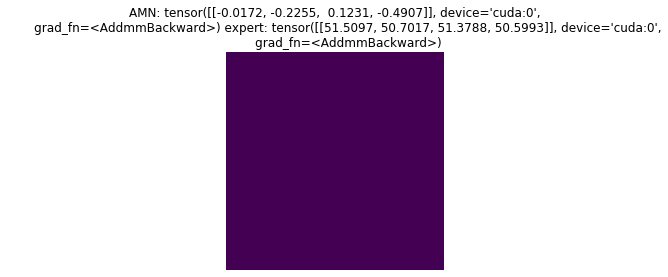

FileNotFoundError: The directory '/mnt/hdd1/ml/Active-Actor-Mimic/experiments/simplified_KGW/gifs' does not exist

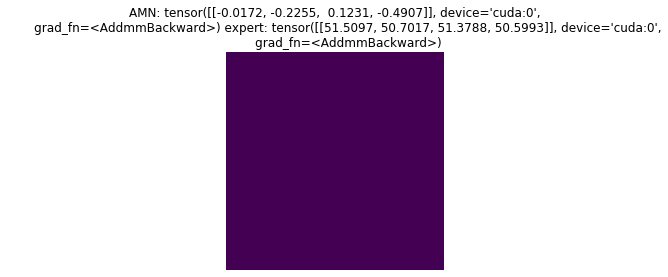

In [12]:
images = visualize_AMN(AMN_net,memory,expert_network=expert_net, device=device)
imageio.mimsave(f'gifs/{NAME}.gif', images)